# Super Simple Keras model on TriFeature for multiplicity determination

In [2]:
label = "nPN"
nmax = 4
dp = 12

In [3]:
import sys
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

sys.path.append("..")
from helpers import tridata

In [1]:
import tensorflow
from tensorflow import keras

print("tensorflow", tensorflow.__version__)
print("keras", keras.__version__)

tensorflow 2.3.1
keras 2.4.0


In [4]:
traindata, testdata = tridata(distance=15, doubleplane=dp, energy=600, erel=500, nmax=nmax, physics="inclxx")
print(traindata.shape, testdata.shape)

x_train = traindata[["nHits", "nClus", "Edep"]].values
y_train = keras.utils.to_categorical(traindata[[label]].values.ravel())

x_val = testdata[["nHits", "nClus", "Edep"]].values
y_val = keras.utils.to_categorical(testdata[[label]].values.ravel());

(640241, 6) (159759, 6)


In [5]:
models = defaultdict(keras.models.Sequential)

models["(SM)"].add(keras.layers.Dense(units=nmax + 1, activation="softmax"))

models["(10, SM)"].add(keras.layers.Dense(units=10, activation="relu"))
models["(10, SM)"].add(keras.layers.Dense(units=nmax + 1, activation="softmax"))

models["(20, SM)"].add(keras.layers.Dense(units=20, activation="relu"))
models["(20, SM)"].add(keras.layers.Dense(units=nmax + 1, activation="softmax"))

models["(100, SM)"].add(keras.layers.Dense(units=100, activation="relu"))
models["(100, SM)"].add(keras.layers.Dense(units=nmax + 1, activation="softmax"))

models["(100, 10, SM)"].add(keras.layers.Dense(units=100, activation="relu"))
models["(100, 10, SM)"].add(keras.layers.Dense(units=10, activation="relu"))
models["(100, 10, SM)"].add(keras.layers.Dense(units=nmax + 1, activation="softmax"))

optimizer = keras.optimizers.Adam
loss = keras.losses.CategoricalCrossentropy

histories = {}
for name, model in models.items():
    print(name)
    model.compile(loss=loss(), optimizer=optimizer(), metrics=["accuracy"])
    histories[name] = model.fit(
        x=x_train, y=y_train, batch_size=1000, epochs=50, validation_data=(x_val, y_val), verbose=2
    )
    print("----")

(SM)
Epoch 1/50
641/641 - 1s - loss: 103.6527 - accuracy: 0.2623 - val_loss: 13.6655 - val_accuracy: 0.2558
Epoch 2/50
641/641 - 1s - loss: 5.8391 - accuracy: 0.3548 - val_loss: 4.8682 - val_accuracy: 0.3777
Epoch 3/50
641/641 - 1s - loss: 4.3258 - accuracy: 0.3939 - val_loss: 3.8023 - val_accuracy: 0.4083
Epoch 4/50
641/641 - 1s - loss: 3.2177 - accuracy: 0.4191 - val_loss: 2.6185 - val_accuracy: 0.4230
Epoch 5/50
641/641 - 1s - loss: 1.9988 - accuracy: 0.4325 - val_loss: 1.4546 - val_accuracy: 0.4411
Epoch 6/50
641/641 - 1s - loss: 1.2178 - accuracy: 0.4479 - val_loss: 1.1002 - val_accuracy: 0.4641
Epoch 7/50
641/641 - 1s - loss: 1.0791 - accuracy: 0.4766 - val_loss: 1.0681 - val_accuracy: 0.4795
Epoch 8/50
641/641 - 1s - loss: 1.0651 - accuracy: 0.4824 - val_loss: 1.0588 - val_accuracy: 0.4878
Epoch 9/50
641/641 - 1s - loss: 1.0583 - accuracy: 0.4845 - val_loss: 1.0594 - val_accuracy: 0.4837
Epoch 10/50
641/641 - 1s - loss: 1.0549 - accuracy: 0.4840 - val_loss: 1.0525 - val_accuracy

In [6]:
x_test = testdata[["nHits", "nClus", "Edep"]].values
y_true = testdata[[label]].values.ravel()

for name, model in models.items():
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)
    bac = balanced_accuracy_score(y_true, y_pred)
    print(name, bac)

(SM) 0.5634428256839762
(10, SM) 0.5676544791919705
(20, SM) 0.572618174422648
(100, SM) 0.5491130034699412
(100, 10, SM) 0.538043375128219


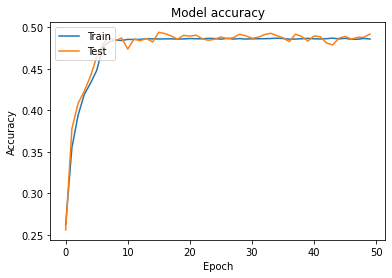

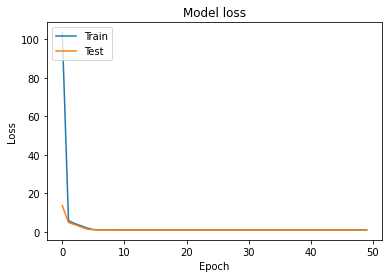

In [7]:
history = histories["(SM)"]

# Plot training & validation accuracy values
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

# Plot training & validation loss values
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

In [8]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

y_pred = models["(20, SM)"].predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

bac = balanced_accuracy_score(y_true, y_pred)
print(bac)
cm = confusion_matrix(y_true, y_pred, labels=range(0, nmax + 1))
print(cm)
cmrel = confusion_matrix(y_true, y_pred, labels=range(0, nmax + 1), normalize="true")
print(cmrel)

0.572618174422648
[[12755     0     0     0     0]
 [    0 21717  8477   361    21]
 [    0 14163 12338  7679  3182]
 [    0  6850  9845 10584 12194]
 [    0  3042  5916  8682 21953]]
[[1.    0.    0.    0.    0.   ]
 [0.    0.71  0.277 0.012 0.001]
 [0.    0.379 0.33  0.206 0.085]
 [0.    0.174 0.249 0.268 0.309]
 [0.    0.077 0.149 0.219 0.554]]
